# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import time
import datetime

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.2799999937415123


In [8]:
#DeepDeterminsticPolicyGradient DDPG
from nn_model import Actor , Critic
from agent import AiAgent

In [9]:
#Test to create the instance of AiAgent
reacherAI = AiAgent(state_size,action_size,random_seed=3)
print(reacherAI.actor_local)
print(reacherAI.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=28, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=1, bias=True)
)


In [10]:
# Deep Determinsitic Policy Gradient Algorithm

def Ddpg(n_episodes=3000, max_t=300, print_every=100):
    print(datetime.datetime.now())
    #Reward Counter - Goal to achieve 30+ 
    scores_ddpg = []
    scores = np.zeros(num_agents) 
    scores_window = deque(maxlen=print_every)  #Window for every 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
        
        #set initial state
        state = env_info.vector_observations  #[0] Current state 
        #Reset
        reacherAI.reset()
        reward = 0
       
        
        while True: # t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            #action = np.clip(action, -1, 1) #np.clip (0 or 1 )taken care in Agent.Act
            
            #Perform 'action'
            env_info = env.step(action)[brain_name]
            #Next State 
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done   = env_info.local_done
            scores += reward                       
            #Learning using Replay Buffer to REINFORCE which policy is best probabity to choose
            if done :
                reacherAI.step (state, action,scores,next_state,done)
            #New Observation set for AIAgent to set as Current state
            state = next_state
           
            if np.any(done):
                break
        #Windows Scores update    
        scores_window.append(scores)
        scores_ddpg.append(scores)
            
        print('\rEpisode {}\tAverage Score: {:.4f} '.format(i_episode,np.mean(scores)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores)>=30.0 and i_episode >100 :
            #time_taken = time.time() - start_time
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores)))
            torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor30.pth')
            torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic30.pth')
            #print ('AiReacher took {} hrs & {} mins to solve the env in {} episodes '.format(int(time_taken/3600),int(time_taken/60,i_episode)))
            
            break
              
                   
    return scores_ddpg


2020-07-21 13:57:17.113675
Episode 100	Average Score: 0.7000 
Episode 200	Average Score: 3.0400 
Episode 300	Average Score: 4.9200 
Episode 400	Average Score: 7.0400 
Episode 500	Average Score: 9.7200 
Episode 600	Average Score: 11.6900 
Episode 700	Average Score: 14.2900 
Episode 800	Average Score: 17.8700 
Episode 900	Average Score: 22.0000 
Episode 1000	Average Score: 26.7700 
Episode 1100	Average Score: 28.8000 
Episode 1200	Average Score: 29.7400 
Episode 1243	Average Score: 30.1600 
Environment solved in 1243 episodes!	Average Score: 30.1600
2020-07-21 21:24:18.656731


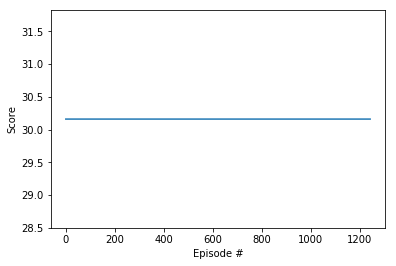

In [11]:
#Ver 7.7 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.00013         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0  
#seed 3

scores = Ddpg(n_episodes=5000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [16]:
env.close()

# Background work - 

In [14]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(1000):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  

Total score (averaged over agents) this episode: 0.0


In [ ]:
#Ver 7.7 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 128        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg(n_episodes=5000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 13:31:12.877648
Episode 100	Average Score: 0.3600 
Episode 165	Average Score: 0.5100 

In [ ]:
#Ver 7.6 20Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 128        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg(n_episodes=5000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 06:43:24.765966
Episode 100	Average Score: 2.4500 
Episode 200	Average Score: 4.4300 
Episode 300	Average Score: 6.3400 
Episode 400	Average Score: 7.2400 
Episode 500	Average Score: 8.2200 
Episode 600	Average Score: 9.0900 
Episode 700	Average Score: 10.2400 
Episode 800	Average Score: 10.9700 
Episode 900	Average Score: 11.9300 
Episode 1000	Average Score: 12.6300 
Episode 1100	Average Score: 13.9600 
Episode 1200	Average Score: 15.0700 
Episode 1300	Average Score: 16.1900 
Episode 1361	Average Score: 16.6700 

In [13]:
#Ver 7.5 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 128        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg(n_episodes=3000)
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-21 00:21:28.166461
Episode 100	Average Score: 3.0200 
Episode 200	Average Score: 5.5300 
Episode 300	Average Score: 7.7300 
Episode 400	Average Score: 8.6700 
Episode 500	Average Score: 10.0400 
Episode 600	Average Score: 11.1100 
Episode 700	Average Score: 12.2600 
Episode 800	Average Score: 13.2500 
Episode 900	Average Score: 13.6900 
Episode 1000	Average Score: 14.8900 
Episode 1100	Average Score: 17.1900 
Episode 1200	Average Score: 19.1000 
Episode 1300	Average Score: 20.4300 
Episode 1400	Average Score: 22.3100 
Episode 1500	Average Score: 24.3300 
Episode 1600	Average Score: 27.4600 
Episode 1690	Average Score: 30.0100 

NameError: name 'start_time' is not defined

In [ ]:
#Ver 7.3 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 500        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-20 20:57:50.677770
Episode 100	Average Score: 4.2600 
Episode 200	Average Score: 6.2300 
Episode 300	Average Score: 7.0400 
Episode 400	Average Score: 8.2500 
Episode 405	Average Score: 8.2500 

In [14]:
#Test Run - Trained Agent
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

state = env.reset()
for t in range(200):
    action = reacherAI.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

TypeError: expected np.ndarray (got dict)

When finished, you can close the environment.

In [ ]:
env.close()

In [ ]:
#Ver 7.3 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()
print(datetime.datetime.now())
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

2020-07-20 06:20:32.755652
Episode 100	Average Window Score: 0.2200
Episode 200	Average Window Score: 0.8500
Episode 300	Average Window Score: 2.1800
Episode 400	Average Window Score: 3.1800
Episode 500	Average Window Score: 5.0900
Episode 600	Average Window Score: 7.5000
Episode 700	Average Window Score: 8.3700
Episode 719	Average Score: 8.4700 

In [13]:
#Ver 7.3 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 300        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0002         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Window Score: 1.7100
Episode 200	Average Window Score: 7.0200
Episode 300	Average Window Score: 11.8900
Episode 400	Average Window Score: 13.7100
Episode 500	Average Window Score: 16.9300
Episode 600	Average Window Score: 20.4300
Episode 700	Average Window Score: 22.0900
Episode 800	Average Window Score: 27.2800
Episode 868	Average Score: 30.1100 
Environment solved in 768 episodes!	Average Score: 30.1100


ValueError: int() base must be >= 2 and <= 36

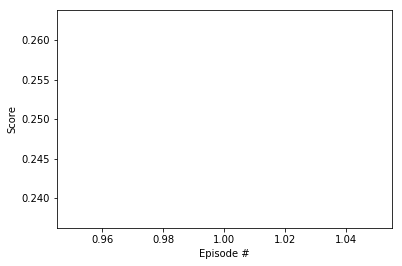

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
TrainedreacherAI = AiAgent(state_size,action_size,random_seed=9)
print(TrainedreacherAI.actor_local)
print(TrainedreacherAI.critic_local)


Actor(
  (fc1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=24, bias=True)
  (fc2): Linear(in_features=28, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=1, bias=True)
)


Increased Buffer size so Replay Memory size wud be larger but Minibatch to see the correlations reduced to 100
Discounted Reward made to .997 
Local to Target Network Sync - updated to 0.0017 Learning rate Actor increased to 0.0002 but for critic made it 0.001

theta=0.1, sigma=0.2 - 
Noise sampling since major challenges cud see during training ..arm is just moving clock wise swing mostly. so need more exploration

In [13]:
TrainedreacherAI.load_state_dict(torch.load('checkpoint_actor30.pth'))
TrainedreacherAI.eval()

AttributeError: 'AiAgent' object has no attribute 'load_state_dict'

In [12]:
#Ver 7 19Jul
#Change params to default
#BUFFER_SIZE = 500000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 100        #128        # minibatch size
#GAMMA = 0.997            # discount factor
#TAU = 0.0013              # for soft update of target parameters
#LR_ACTOR = 0.0001         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   

scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Window Score: 1.3600
Episode 200	Average Window Score: 2.7800
Episode 300	Average Window Score: 3.6100
Episode 400	Average Window Score: 4.3000
Episode 453	Average Score: 5.2800 

KeyboardInterrupt: 

# History


Episode 100	Average Window Score: 11.3031e: 0.00000
Episode 200	Average Window Score: 7.1321e: 0.000000
Episode 300	Average Window Score: 5.1471e: 0.000000
Episode 400	Average Window Score: 10.1139e: 119.0100
Episode 500	Average Window Score: 13.6738e: 39.53000


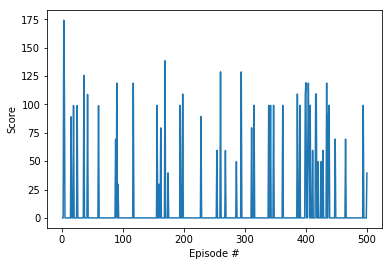

In [18]:
#Ver 5 19Jul
#Change params to default
#BUFFER_SIZE = 300000    #int(1e4)  # replay buffer size
#BATCH_SIZE = 256        #128        # minibatch size
#GAMMA = 0.917            # discount factor
#TAU = 0.001              # for soft update of target parameters
#LR_ACTOR = 1e-4         # learning rate of the actor 
#LR_CRITIC = 1e-3        # learning rate of the critic
#WEIGHT_DECAY = 0   
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

seed 9
BUFFER_SIZE = 300000    #int(1e4)  # replay buffer size
BATCH_SIZE = 256        #128        # minibatch size
GAMMA = 0.917            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#V4 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0143
Episode 200	Average Score: 0.0796
Episode 300	Average Score: 0.0388
Episode 400	Average Score: 0.0536
Episode 500	Average Score: 0.0720
Episode 600	Average Score: 0.0515
Episode 663	Average Score: 0.0382

seed 575
BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.97            # discount factor
TAU = 0.001              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#V3 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0322
Episode 200	Average Score: 0.0328
Episode 300	Average Score: 0.0322
Episode 400	Average Score: 0.0287
Episode 488	Average Score: 0.0229

In [ ]:
#V2.1 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0243
Episode 125	Average Score: 0.0243

BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#V1.2 17-Jul-20
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.0341
Episode 200	Average Score: 0.0613
Episode 300	Average Score: 0.0740
Episode 400	Average Score: 0.0475
Episode 500	Average Score: 0.0214
Episode 580	Average Score: 0.0188

In [ ]:
env.close()

In [ ]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

env_info = env.reset(train_mode=False)[brain_name]
scores = np.zeros(num_agents)       
#set initial state
state = env_info.vector_observations

for t in range(1000):
    action = reacherAI.act(state, add_noise=False)
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations
    reward = env_info.rewards
    done   = env_info.local_done
    scores += reward                       
    state = next_state
           
    if np.any(done):
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))  

In [11]:

def Ddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        #reacherAI.reset()
        #score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations  #[0] Current state 
        reacherAI.reset()
        total_Reward = np.zeros(num_agents)
        for t in range(max_t):
            #Select action based on  policy based
            action = reacherAI.act(state)
            action = np.clip(action, -1, 1) 
            #Perform 'action'
            env_info = env.step(action)[brain_name]
            
            #Next State 
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done   = env_info.local_done
            total_Reward += env_info.rewards
            
            state = next_state
            #Replay Memory
            [reacherAI.step(state[i], action[i], reward[i], next_state[i], done[i]) for i in range(num_agents)]
            #reacherAI.step(state, action, reward, next_state, done)
            
            reacherAI.step_learn()
            
            
            if np.any(done):
                break 
        scores_deque.append(np.mean(total_Reward))
        scores.append(np.mean(total_Reward))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(reacherAI.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(reacherAI.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores



#Background Work

In [ ]:
#V1.2 hyper params 17-Jul-20 3.40PM  
random_seed = 1
BUFFER_SIZE = int(1e4)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [ ]:
#Call DDPG
scores = Ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
print (torch.__version__)

In [ ]:
conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

In [ ]:
reacherAI.actor_local.load_state_dict(torch.load('checkpoint_actor30.pth'))
reacherAI.critic_local.load_state_dict(torch.load('checkpoint_critic30.pth'))

state = env.reset()
for t in range(200):
    action = agent.act(state, add_noise=False)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 


In [ ]:
#

In [ ]:
#Train the Agent - DDPG  Algorithm - simillar from AiNavigator -DQN approach
#Function dqn helps to calculate Agent's optimized score to choose Actor-critic Method
def DDPG(num_episodes=1000, max_t=300, print_every=100):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    

    for i_episode in range(1,num_episodes+1):
        #reset the unity Env_info for each new episode
        env_info = env.reset(train_mode=True)[brain_name]
    
        #set initial state 
        state = env_info.vector_observations[0]
    
        score = 0 
        #Iterative run until all number of episodes done
    
        while True:
            action = ai_agent.act(state,eps)
        
            env_info = env.step(action)[brain_name]        #Take action based on Epsilion Greedy Policy
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished 
            
            ai_agent.step(state, action, reward, next_state, done) # Replay Memory - Learn from potential failure
            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step            
            if done:                                       # exit loop if episode finished
                break
            
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=17.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(ai_agent.qnetwork_local.state_dict(), 'checkpointai17.pth')
            break
        
    return scores     

When finished, you can close the environment.

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 